# 111261012 張晉瑜

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

file_prefix = "E:/school/大學/專題/data/20240829/20240829_degree_"

degree_trans_label = {
    "000_":0,"045_":1,"090_":2,"135_":3,"180_":4,
}

degree = ["000_","045_","090_","135_","180_"]
hight = ["low_","mid_","high_"]       #training data
freq = ["500","1000","1500","2000"]   #training data
t_hight = ["low_","mid_"]             #testing data
t_freq = ["2000",]                    #testing data

file_list = []
t_file_list = []
label_list = []
t_label_list = []



# init the file list and label list 
for d in degree:
    for h in hight:
        for f in freq:
            file_list.append(file_prefix + d + h + f + "Hz.wav")
            label_list.append(degree_trans_label[d])

# init the testing data set
for d in degree:
    for h in t_hight:
        for f in t_freq:
            t_file_list.append(file_prefix + d + h + f + "Hz.wav")
            t_label_list.append(degree_trans_label[d])



class trans_dataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        y, sr = librosa.load(file_path)

        # cut the time-frame s.t size of mel_spectro are the same (225 and 675 are the values of exp)
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)[:,225:675]
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

        mel_spect = torch.tensor(mel_spect, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        return mel_spect, label

dataset = trans_dataset(file_list, label_list)
test_dataset = trans_dataset(t_file_list,t_label_list)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


# 這邊有錯 shape有錯
class Classifier_5_deg(nn.Module):
    def __init__(self):
        super(Classifier_5_deg, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)  # output [32, 128, 450]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1) # output [64, 128, 450]
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)  #pooling
        self.fc1 = nn.Linear(64 * 32 * 112, 128)  # assume shape is  128x450
        self.fc2 = nn.Linear(128, 5)  # 5 class
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # print(f'Shape before flattening: {x.shape}')
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))     #ReLU
        x = self.fc2(x)
    
        return x

model = Classifier_5_deg()

# loss func
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # L2 norm


# train
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.unsqueeze(1)  # add dim [batch, 1, H, W]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')

train_model(model, train_loader, criterion, optimizer)




Epoch [1/100], Loss: 425.8998
Epoch [2/100], Loss: 201.9569
Epoch [3/100], Loss: 9.0071
Epoch [4/100], Loss: 1.6334
Epoch [5/100], Loss: 1.6085
Epoch [6/100], Loss: 1.6097
Epoch [7/100], Loss: 1.6099
Epoch [8/100], Loss: 1.6502
Epoch [9/100], Loss: 1.6101
Epoch [10/100], Loss: 1.6117
Epoch [11/100], Loss: 1.6091
Epoch [12/100], Loss: 1.6097
Epoch [13/100], Loss: 1.6091
Epoch [14/100], Loss: 1.6087
Epoch [15/100], Loss: 1.6096
Epoch [16/100], Loss: 1.6492
Epoch [17/100], Loss: 1.6087
Epoch [18/100], Loss: 1.6091
Epoch [19/100], Loss: 1.6095
Epoch [20/100], Loss: 1.6094
Epoch [21/100], Loss: 1.6093
Epoch [22/100], Loss: 1.6084
Epoch [23/100], Loss: 1.6092
Epoch [24/100], Loss: 1.6095
Epoch [25/100], Loss: 1.6087
Epoch [26/100], Loss: 1.6086
Epoch [27/100], Loss: 1.6104
Epoch [28/100], Loss: 1.6095
Epoch [29/100], Loss: 1.6082
Epoch [30/100], Loss: 2.0517
Epoch [31/100], Loss: 1.6081
Epoch [32/100], Loss: 1.6074
Epoch [33/100], Loss: 1.6054
Epoch [34/100], Loss: 1.6069
Epoch [35/100], Los

In [18]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset, batch_size=16, shuffle=False)


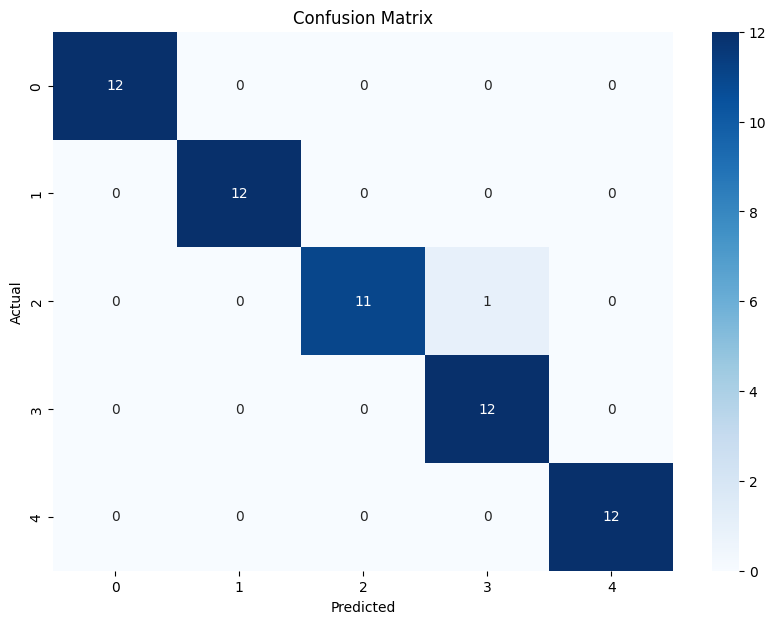

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_confusion_matrix(model, data_loader, device):
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.unsqueeze(1)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # get pred class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # span confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)

    # plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader, device)
